In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import scipy.stats as ss
from scipy.stats import expon, norm, gamma, beta, lognorm
from scipy.stats._continuous_distns import beta_gen, gamma_gen
from scipy import stats
from datetime import datetime, timedelta

# EDA

## Daten einlesen

In [2]:
def trim_non_visible(s):
    """Strip if s is a string, otherwise return s."""
    if isinstance(s, str):
        return s.strip()
    return s


def read_data(file):
    """Reads the first 4 columns from the given file and drops empty rows."""
    data = pd.read_csv(
        file, delimiter=",", usecols=[0, 1, 2, 3], parse_dates=[[0, 1]]
    )
    data.columns = ["datetime", "kg", "m/s"]
    data = data[data["datetime"] != "nan nan"]
    data = data.dropna(how="all")
    data["datetime"] = pd.to_datetime(data["datetime"])
    data = data.applymap(trim_non_visible)
    return data.sort_values(by=["datetime"])

In [3]:
zone1 = read_data("data/out_1.csv")
zone2 = read_data("data/out_2.csv")

In [4]:
pd.concat([zone1, zone2], axis=1, keys=["zone1", "zone2"]).describe()

zone1                           
                            datetime           kg        m/s   
count                             68    68.000000  68.000000  \
mean   2019-02-12 22:08:49.411764736   628.632353   8.788235   
min              2019-01-01 09:00:00    12.000000   3.600000   
25%              2019-01-23 23:00:00   214.750000   7.300000   
50%              2019-02-14 03:00:00   402.500000   8.800000   
75%              2019-03-03 09:30:00   773.000000  10.125000   
max              2019-03-27 16:00:00  3104.000000  14.100000   
std                              NaN   695.884703   1.989189   

                     zone2                         
                  datetime          kg        m/s  
count                   32   32.000000  32.000000  
mean   2019-02-11 15:48:45   99.250000  37.790625  
min    2019-01-01 09:00:00    0.000000  24.900000  
25%    2019-01-17 17:00:00   36.750000  33.200000  
50%    2019-02-12 12:30:00   58.000000  38.750000  
75%    2019-03-10 17:45:00  140.000000  41.725000  
max    2019-03-28 01:00:00  406.000000  46.500000  
std                    NaN  104.072555   5.395778

In [5]:
zone1.head()

,datetime,kg,m/s
0,2019-01-01 09:00:00,194.0,8.4
1,2019-01-01 21:00:00,224.0,8.8
2,2019-01-02 14:00:00,3104.0,9.2
3,2019-01-04 15:00:00,228.0,8.0
4,2019-01-05 23:00:00,755.0,7.0


In [6]:
print(zone2.isna().sum())

datetime    0
kg          0
m/s         0
dtype: int64


## NAs

In [7]:
# Check for NaN values
print(zone1.isna().sum())

# Check for zeros
print(zone1.eq(0).sum())

datetime    0
kg          0
m/s         0
dtype: int64
datetime    0
kg          0
m/s         0
dtype: int64


In [8]:
# Drop lines with only NA values
zone1 = zone1.dropna(how="all")
print(zone1.isna().sum())

datetime    0
kg          0
m/s         0
dtype: int64


In [9]:
# Check for NaN values
print(zone2.isna().sum())

# Check for zeros
print(zone2.eq(0).sum())

datetime    0
kg          0
m/s         0
dtype: int64
datetime    0
kg          1
m/s         0
dtype: int64


Ein Stein hat keine Masse und muss beachtet werden.

In [10]:
# Drop lines with only NA values
zone2 = zone2.dropna(how="all")
print(zone2.isna().sum())

datetime    0
kg          0
m/s         0
dtype: int64


## Stein mit 0 Masse

In [11]:
# Set the value to the median in the row where 'kg' equals 0.0
# This rock is not removed from the data, because we do not have a lot of data and this might just have been an error in the measurement
zone2.loc[zone2["kg"] == 0.0, "kg"] = zone2["kg"].median()
# TODO: try to drop the row and check if there is a difference? or go up to 1? -> how do the parameters change (don't run simulation)?

In [12]:
pd.concat([zone1, zone2], axis=1, keys=["zone1", "zone2"]).describe()

zone1                           
                            datetime           kg        m/s   
count                             68    68.000000  68.000000  \
mean   2019-02-12 22:08:49.411764736   628.632353   8.788235   
min              2019-01-01 09:00:00    12.000000   3.600000   
25%              2019-01-23 23:00:00   214.750000   7.300000   
50%              2019-02-14 03:00:00   402.500000   8.800000   
75%              2019-03-03 09:30:00   773.000000  10.125000   
max              2019-03-27 16:00:00  3104.000000  14.100000   
std                              NaN   695.884703   1.989189   

                     zone2                         
                  datetime          kg        m/s  
count                   32   32.000000  32.000000  
mean   2019-02-11 15:48:45  101.062500  37.790625  
min    2019-01-01 09:00:00    3.000000  24.900000  
25%    2019-01-17 17:00:00   37.750000  33.200000  
50%    2019-02-12 12:30:00   58.000000  38.750000  
75%    2019-03-10 17:45:00  140.000000  41.725000  
max    2019-03-28 01:00:00  406.000000  46.500000  
std                    NaN  102.785382   5.395778

In [13]:
print(zone2.eq(0).sum())

datetime    0
kg          0
m/s         0
dtype: int64


## Energie und Zeitdifferenz berechnen

In [14]:
def _get_time_differences(df):
    """Returns the time differences between rocks in hours."""
    return df["datetime"].diff().dt.total_seconds() / 3600


def add_time_differences(df):
    """Adds the time differences to the dataframe."""
    df["timediv h"] = _get_time_differences(df)

    # TODO: why median?
    # replace NA with 0 in the column timediv h
    df["timediv h"] = df["timediv h"].fillna(0)
    # replace 0 with median of timediv h in the column timediv h
    df["timediv h"] = df["timediv h"].replace(0, df["timediv h"].median())

    return df


def add_energy(df):
    """Adds the energy to the dataframe."""
    df["kj"] = 0.5 * df["kg"] * df["m/s"] ** 2 / 1000
    return df

In [15]:
zone1 = add_time_differences(add_energy(zone1))
zone2 = add_time_differences(add_energy(zone2))
print(zone1.head())
print(zone2.head())

             datetime      kg  m/s         kj  timediv h
0 2019-01-01 09:00:00   194.0  8.4    6.84432       22.0
1 2019-01-01 21:00:00   224.0  8.8    8.67328       12.0
2 2019-01-02 14:00:00  3104.0  9.2  131.36128       17.0
3 2019-01-04 15:00:00   228.0  8.0    7.29600       49.0
4 2019-01-05 23:00:00   755.0  7.0   18.49750       32.0
             datetime     kg   m/s         kj  timediv h
0 2019-01-01 09:00:00   38.0  45.4   39.16204       48.5
1 2019-01-03 06:00:00  187.0  41.6  161.80736       45.0
2 2019-01-04 10:00:00   36.0  44.6   35.80488       28.0
3 2019-01-07 14:00:00    6.0  41.2    5.09232       76.0
4 2019-01-11 06:00:00   65.0  39.6   50.96520       88.0


## Visualisierung

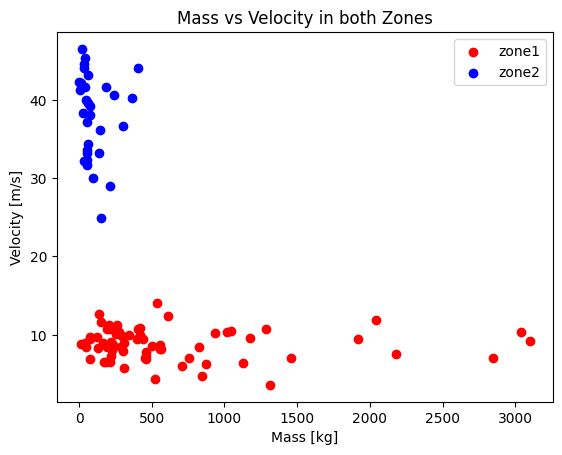

In [16]:
fig, ax = plt.subplots()
ax.scatter(zone1["kg"], zone1["m/s"], c="red", label="zone1")
ax.scatter(zone2["kg"], zone2["m/s"], c="blue", label="zone2")
ax.legend()
ax.axes.set_xlabel("Mass [kg]")
ax.axes.set_ylabel("Velocity [m/s]")
plt.title("Mass vs Velocity in both Zones")
plt.show()

Zonen 1 und 2 sollten nicht gemischt werden, da sie nicht teil von der gleichen Grundgesamtheit sind.

In [17]:
def scatter_plot(
    df: pd.DataFrame,
    col: str,
    colorbar=False,
    title=None,
):
    """Plots the given column of the given data frame as a scatter plot."""
    if title is None:
        title = f"{col.upper()} vs. Date"
    title = title + f"\nnumber of records: {len(df)}"
    df["datetime"] = pd.to_datetime(df["datetime"])
    ax = df.plot.scatter(x="datetime", y=col, colorbar=colorbar)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.title(
        f"{col} vs. date\nnumber of records: {len(df)}"
        if title is None
        else title
    )
    plt.xticks(rotation=90)


def plot_histogram(df: pd.DataFrame, col: str, zone: int, title: str = None):
    """Plots the given column of the given dataframe as a histogram."""
    if title is None:
        title = f"{col.upper()} for Zone {zone}"
    title = title + f"\nnumber of records: {len(df)}"
    df[col].hist(bins=np.sqrt(len(df[col])).astype(int) * 6)
    plt.xlabel(col.upper())
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

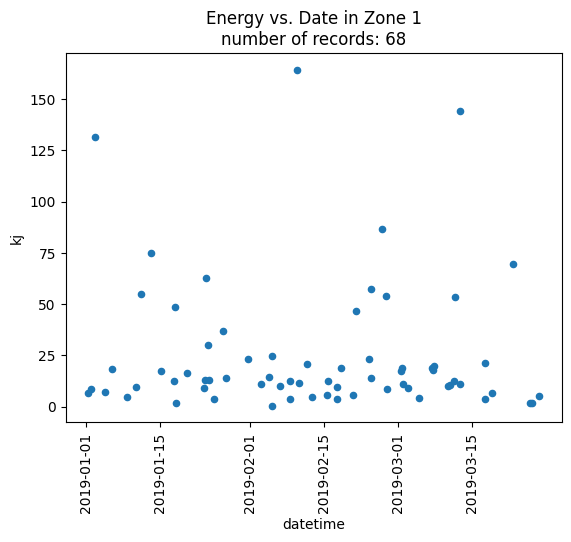

In [18]:
scatter_plot(zone1, "kj", title="Energy vs. Date in Zone 1")

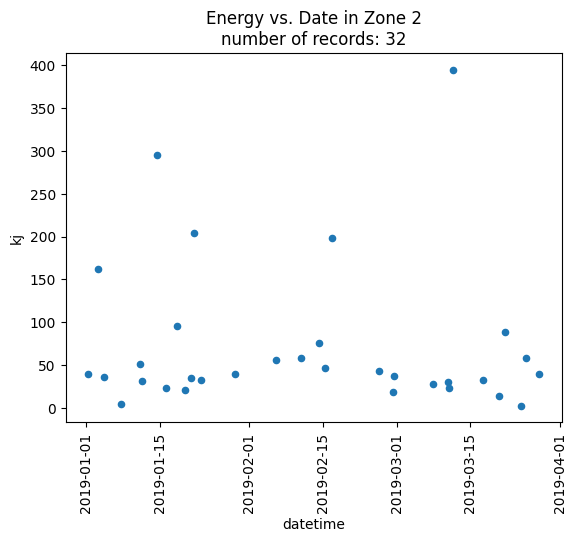

In [19]:
scatter_plot(zone2, "kj", title="Energy vs. Date in Zone 2")

Energie der zweiten Zone ist höher da es schnellere Steine sind. Dies ist der Fall, obwohl sie leichter sind, da die Geschwindigkeit quadratisch in die Energie eingeht.

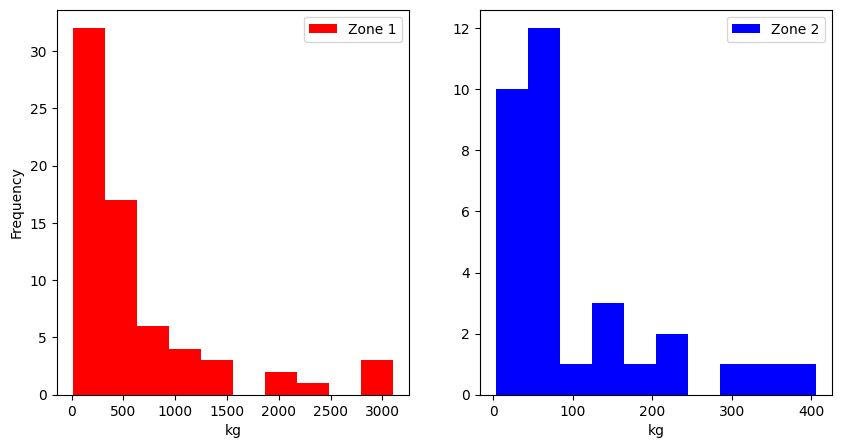

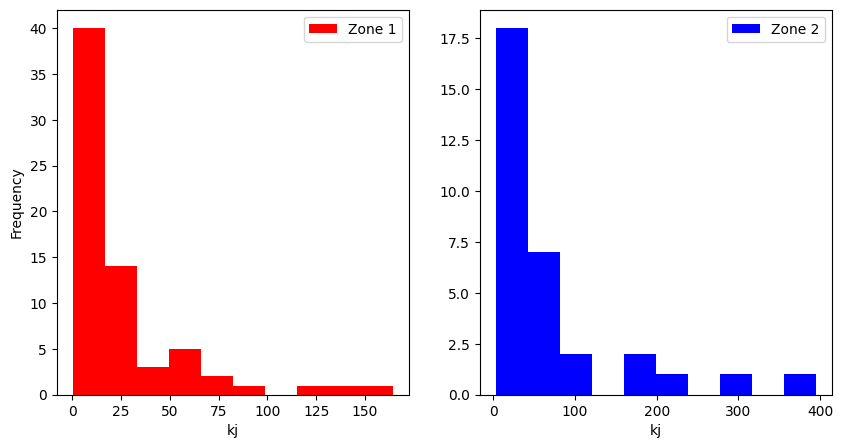

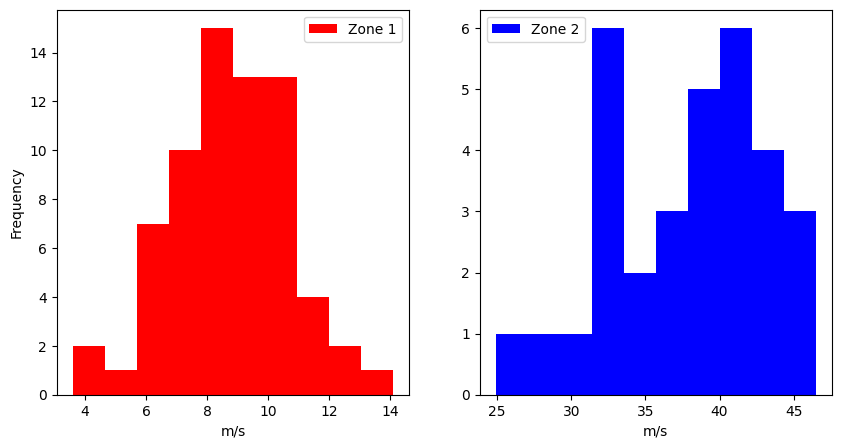

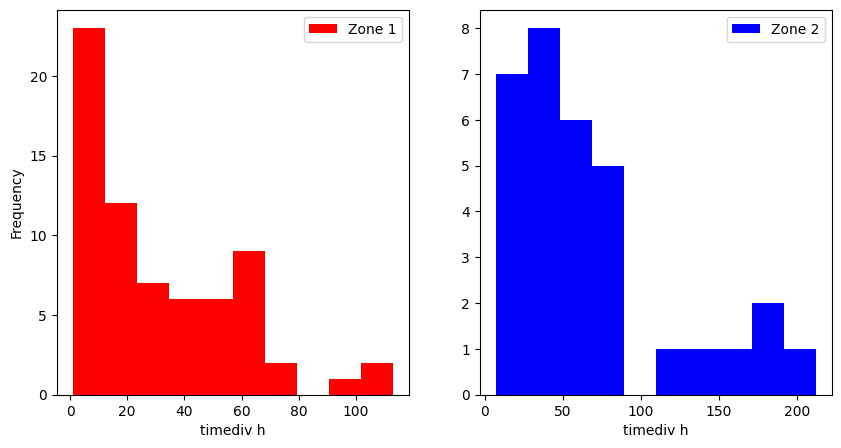

In [20]:
num_bins = 10

# Plot the histograms for 'kg'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["kg"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["kg"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("kg")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("kg")
ax2.legend()
plt.show()

# Plot the histograms for 'kj'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["kj"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["kj"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("kj")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("kj")
ax2.legend()
plt.show()

# Plot the histograms for 'm/s'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["m/s"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["m/s"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("m/s")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("m/s")
ax2.legend()
plt.show()

# Plot the histograms for 'timediv h'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1["timediv h"], bins=num_bins, color="red", label="Zone 1")
ax2.hist(zone2["timediv h"], bins=num_bins, color="blue", label="Zone 2")

ax1.set_xlabel("timediv h")
ax1.set_ylabel("Frequency")
ax1.legend()
ax2.set_xlabel("timediv h")
ax2.legend()
plt.show()

In [21]:
pd.concat([zone1, zone2], axis=1, keys=["zone1", "zone2"]).describe()

zone1                                       
                            datetime           kg        m/s          kj   
count                             68    68.000000  68.000000   68.000000  \
mean   2019-02-12 22:08:49.411764736   628.632353   8.788235   25.197761   
min              2019-01-01 09:00:00    12.000000   3.600000    0.464640   
25%              2019-01-23 23:00:00   214.750000   7.300000    8.214900   
50%              2019-02-14 03:00:00   402.500000   8.800000   12.815133   
75%              2019-03-03 09:30:00   773.000000  10.125000   23.135955   
max              2019-03-27 16:00:00  3104.000000  14.100000  164.403200   
std                              NaN   695.884703   1.989189   32.704933   

                                 zone2                                      
        timediv h             datetime          kg        m/s          kj   
count   68.000000                   32   32.000000  32.000000   32.000000  \
mean    31.073529  2019-02-11 15:48:45  101.062500  37.790625   72.543707   
min      1.000000  2019-01-01 09:00:00    3.000000  24.900000    2.683935   
25%      6.750000  2019-01-17 17:00:00   37.750000  33.200000   29.600176   
50%     22.000000  2019-02-12 12:30:00   58.000000  38.750000   39.581020   
75%     49.000000  2019-03-10 17:45:00  140.000000  41.725000   63.103560   
max    113.000000  2019-03-28 01:00:00  406.000000  46.500000  394.796430   
std     27.085997                  NaN  102.785382   5.395778   87.452601   

                   
        timediv h  
count   32.000000  
mean    65.765625  
min      7.000000  
25%     28.750000  
50%     50.250000  
75%     77.250000  
max    212.000000  
std     54.372815

Alle Steine haben eine Masse und eine Geschwindigkeit. Die Maximale Energie liegt bei ~394 was noch über 100kj unter dem Grenzwert liegt, welcher bei vollem Netz definiert wurde.

# Analyse der Verteilungen der Variablen

In [22]:
def cdf_fit(data):
    distributions = [ss.norm, ss.lognorm, ss.expon, ss.gamma]

    # Plot the CDF of the data and the fitted distributions
    plt.hist(
        data,
        bins=len(data),
        density=True,
        cumulative=True,
        alpha=0.5,
        label="Data",
    )
    x = np.linspace(data.min(), data.max() * 1.2, 100)

    for dist in distributions:
        params = dist.fit(data)
        ll = -dist.logpdf(data, *params).sum().round(0)
        plt.plot(x, dist(*params).cdf(x), label=f"{dist.name}, score: {ll}")
        plt.xlabel(data.name)
        plt.ylabel("Cumulative probability")
        plt.legend()

    plt.show()

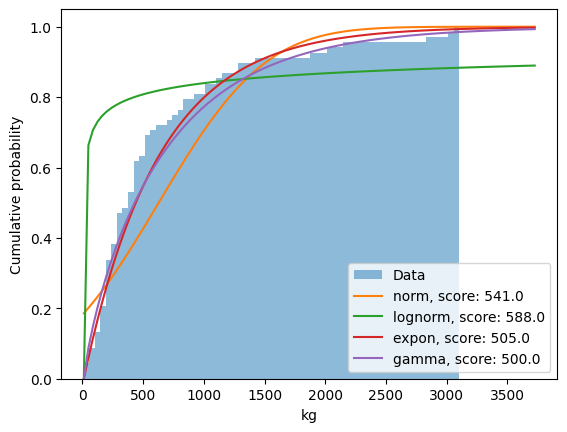

In [23]:
cdf_fit(zone1["kg"])

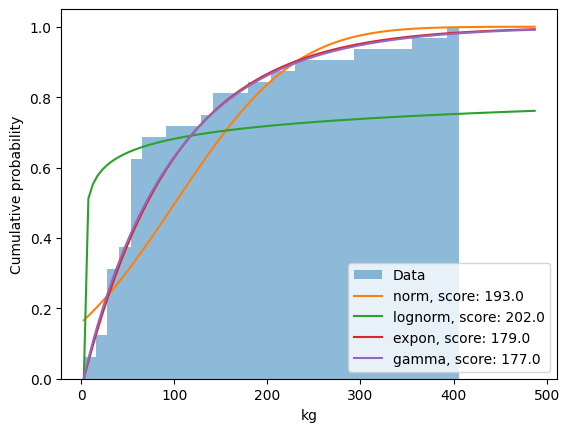

In [24]:
cdf_fit(zone2["kg"])

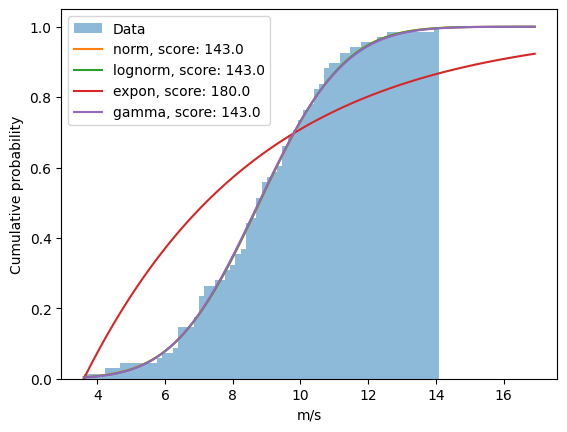

In [25]:
cdf_fit(zone1["m/s"])

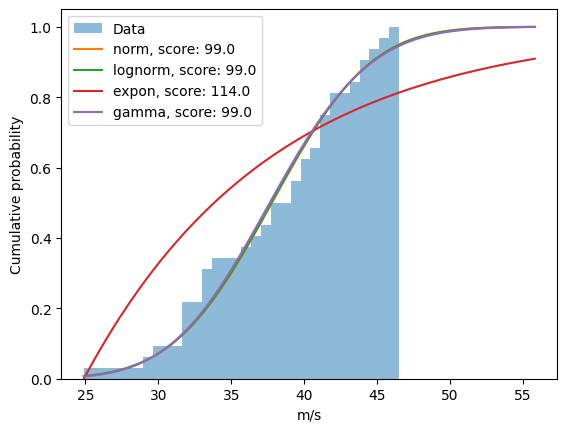

In [26]:
cdf_fit(zone2["m/s"])

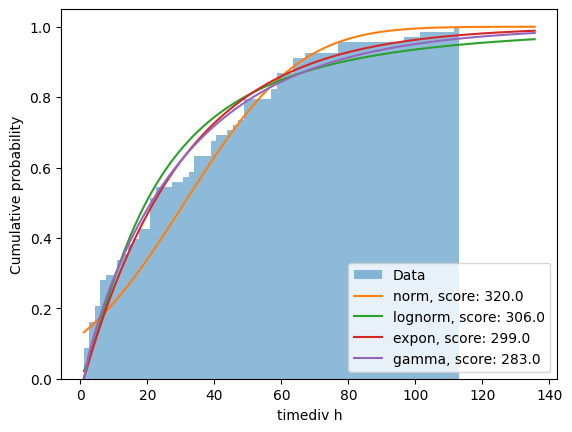

In [27]:
cdf_fit(zone1["timediv h"])

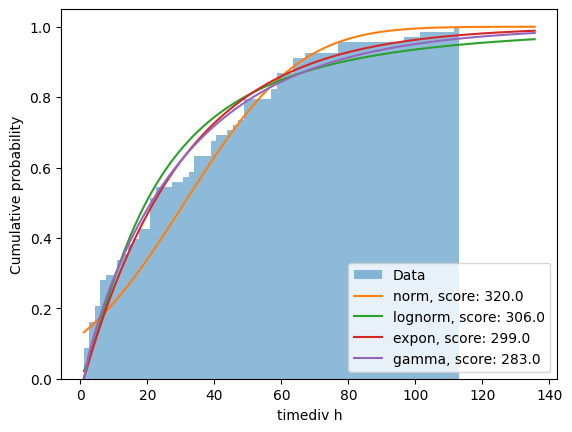

In [28]:
cdf_fit(zone1["timediv h"])

# Monte Carlo Simulation

In [29]:
# to simulate a dataframe for the next number of years it will estimate the number of events it takes and generate a frame
def simulate_zone(zone_df, num_years=200):
    timediv_mean = zone_df["timediv h"].mean()

    # Calculate  the deviation
    timediv_params = expon.fit(zone_df["timediv h"])
    kg_params = gamma.fit(zone_df["kg"])
    v_params = norm.fit(zone_df["m/s"])
    # Calculate number of observations for given number of years
    total_hours = num_years * 365.25 * 24
    num_observations = int(total_hours / timediv_mean)

    # Set the starting datetime to January 1st, 2000, 00:00:00
    current_datetime = datetime(2000, 1, 1, 0, 0, 0)

    # Initialize the new dataframe and generate the data
    simulated_df = pd.DataFrame(index=range(num_observations))
    simulated_df["timediv h"] = (
        expon(*timediv_params).rvs(size=num_observations).round(0)
    )
    simulated_df["datetime"] = (
        simulated_df["timediv h"]
        .cumsum()
        .apply(lambda x: current_datetime + timedelta(hours=x))
    )
    simulated_df["kg"] = gamma(*kg_params).rvs(size=num_observations).round(0)
    simulated_df["m/s"] = norm(*v_params).rvs(size=num_observations).round(1)
    simulated_df["kj"] = (
        0.5 * simulated_df["kg"] * (simulated_df["m/s"] ** 2) / 1000
    )

    return simulated_df

## Test der Sumulation

In [30]:
# simulated zones
simulated1 = simulate_zone(zone1)
simulated1["zone"] = 1
simulated2 = simulate_zone(zone2)
simulated2["zone"] = 2
simulated1.describe()
# m/s is the min 0 which is not possible

,timediv h,datetime,kg,m/s,kj,zone
count,56421.000000,56421,56421.000000,56421.000000,56421.000000,56421.0
mean,30.978111,2099-07-12 21:58:26.843196928,680.803389,8.792019,27.580595,1.0
min,1.000000,2000-01-04 11:00:00,12.000000,0.600000,0.016640,1.0
25%,10.000000,2049-12-16 15:00:00,163.000000,7.500000,5.580920,1.0
50%,22.000000,2099-07-03 16:00:00,434.000000,8.800000,15.658020,1.0
75%,42.000000,2148-12-18 13:00:00,934.000000,10.100000,36.170375,1.0
max,353.000000,2199-05-22 16:00:00,9677.000000,16.800000,708.404785,1.0
std,29.991462,NaN,745.314960,1.970471,35.014685,0.0


In [31]:
pd.concat([zone1, simulated1], axis=1, keys=["zone1", "simulated1"]).describe()

zone1                                       
                            datetime           kg        m/s          kj   
count                             68    68.000000  68.000000   68.000000  \
mean   2019-02-12 22:08:49.411764736   628.632353   8.788235   25.197761   
min              2019-01-01 09:00:00    12.000000   3.600000    0.464640   
25%              2019-01-23 23:00:00   214.750000   7.300000    8.214900   
50%              2019-02-14 03:00:00   402.500000   8.800000   12.815133   
75%              2019-03-03 09:30:00   773.000000  10.125000   23.135955   
max              2019-03-27 16:00:00  3104.000000  14.100000  164.403200   
std                              NaN   695.884703   1.989189   32.704933   

                     simulated1                                                
        timediv h     timediv h                       datetime            kg   
count   68.000000  56421.000000                          56421  56421.000000  \
mean    31.073529     30.978111  2099-07-12 21:58:26.843196928    680.803389   
min      1.000000      1.000000            2000-01-04 11:00:00     12.000000   
25%      6.750000     10.000000            2049-12-16 15:00:00    163.000000   
50%     22.000000     22.000000            2099-07-03 16:00:00    434.000000   
75%     49.000000     42.000000            2148-12-18 13:00:00    934.000000   
max    113.000000    353.000000            2199-05-22 16:00:00   9677.000000   
std     27.085997     29.991462                            NaN    745.314960   

                                            
                m/s            kj     zone  
count  56421.000000  56421.000000  56421.0  
mean       8.792019     27.580595      1.0  
min        0.600000      0.016640      1.0  
25%        7.500000      5.580920      1.0  
50%        8.800000     15.658020      1.0  
75%       10.100000     36.170375      1.0  
max       16.800000    708.404785      1.0  
std        1.970471     35.014685      0.0

In [32]:
pd.concat([zone2, simulated2], axis=1, keys=["zone2", "simulated2"]).describe()

zone2                                                  
                  datetime          kg        m/s          kj   timediv h   
count                   32   32.000000  32.000000   32.000000   32.000000  \
mean   2019-02-11 15:48:45  101.062500  37.790625   72.543707   65.765625   
min    2019-01-01 09:00:00    3.000000  24.900000    2.683935    7.000000   
25%    2019-01-17 17:00:00   37.750000  33.200000   29.600176   28.750000   
50%    2019-02-12 12:30:00   58.000000  38.750000   39.581020   50.250000   
75%    2019-03-10 17:45:00  140.000000  41.725000   63.103560   77.250000   
max    2019-03-28 01:00:00  406.000000  46.500000  394.796430  212.000000   
std                    NaN  102.785382   5.395778   87.452601   54.372815   

         simulated2                                                
          timediv h                       datetime            kg   
count  26658.000000                          26658  26658.000000  \
mean      65.453222  2099-05-29 18:35:53.274813440    101.714870   
min        7.000000            2000-01-02 06:00:00      3.000000   
25%       24.000000            2049-06-21 21:00:00     29.000000   
50%       48.000000            2099-05-18 04:30:00     70.000000   
75%       88.000000            2149-01-05 01:15:00    141.000000   
max      615.000000            2199-01-19 04:00:00   1011.000000   
std       58.222709                            NaN    101.501579   

                                            
                m/s            kj     zone  
count  26658.000000  26658.000000  26658.0  
mean      37.792741     74.284591      2.0  
min       16.500000      0.930015      2.0  
25%       34.200000     20.089350      2.0  
50%       37.800000     48.157300      2.0  
75%       41.400000     99.923808      2.0  
max       57.700000    979.219610      2.0  
std        5.310018     79.742873      0.0

In [33]:
simulated2.head()

,timediv h,datetime,kg,m/s,kj,zone
0,30.0,2000-01-02 06:00:00,77.0,44.8,77.271040,2
1,58.0,2000-01-04 16:00:00,99.0,47.9,113.573295,2
2,164.0,2000-01-11 12:00:00,24.0,42.1,21.268920,2
3,108.0,2000-01-16 00:00:00,94.0,51.6,125.140320,2
4,151.0,2000-01-22 07:00:00,395.0,28.2,157.059900,2


In [34]:
simulated2.tail()

,timediv h,datetime,kg,m/s,kj,zone
26653,44.0,2199-01-07 15:00:00,15.0,31.4,7.394700,2
26654,94.0,2199-01-11 13:00:00,106.0,43.4,99.828680,2
26655,16.0,2199-01-12 05:00:00,9.0,44.4,8.871120,2
26656,151.0,2199-01-18 12:00:00,160.0,25.4,51.612800,2
26657,16.0,2199-01-19 04:00:00,57.0,29.9,25.479285,2


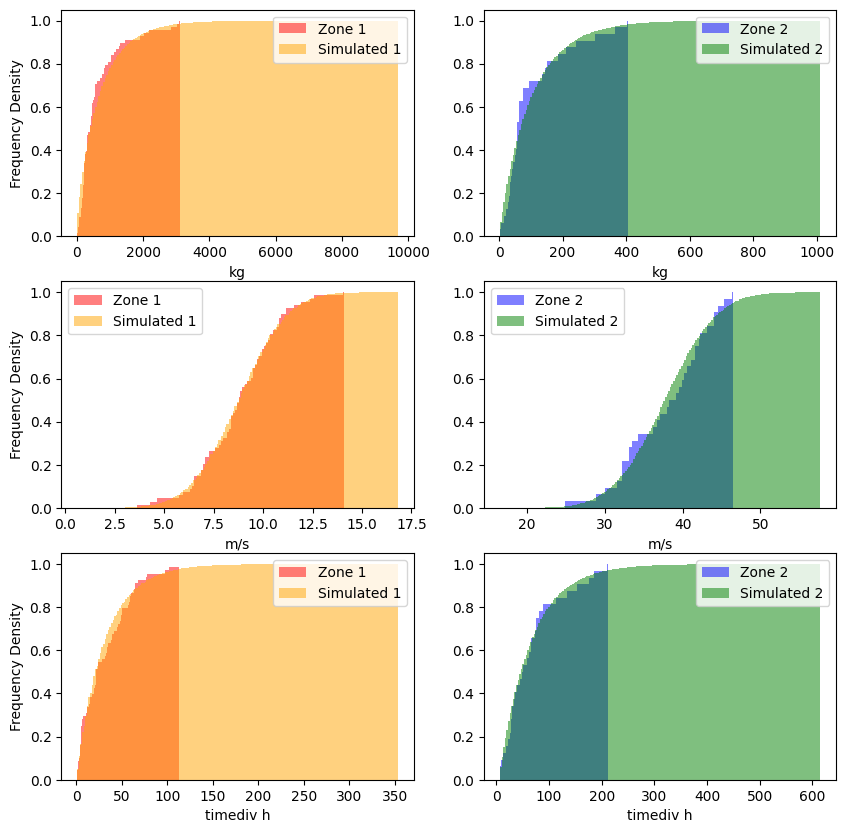

In [35]:
# Set variables
num_bins = 200
cumulative = True

# Plot the histograms for 'kg', 'm/s', and 'timediv h'
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    3, 2, figsize=(10, 10)
)

# Histogram for 'kg'
ax1.hist(
    zone1["kg"],
    bins=num_bins,
    color="red",
    alpha=0.5,
    label="Zone 1",
    density=True,
    cumulative=cumulative,
)
ax1.hist(
    simulated1["kg"],
    bins=num_bins,
    color="orange",
    alpha=0.5,
    label="Simulated 1",
    density=True,
    cumulative=cumulative,
)
ax2.hist(
    zone2["kg"],
    bins=num_bins,
    color="blue",
    alpha=0.5,
    label="Zone 2",
    density=True,
    cumulative=cumulative,
)
ax2.hist(
    simulated2["kg"],
    bins=num_bins,
    color="green",
    alpha=0.5,
    label="Simulated 2",
    density=True,
    cumulative=cumulative,
)

ax1.set_xlabel("kg")
ax1.set_ylabel("Frequency Density")
ax1.legend()
ax2.set_xlabel("kg")
ax2.legend()

# Histogram for 'm/s'
ax3.hist(
    zone1["m/s"],
    bins=num_bins,
    color="red",
    alpha=0.5,
    label="Zone 1",
    density=True,
    cumulative=cumulative,
)
ax3.hist(
    simulated1["m/s"],
    bins=num_bins,
    color="orange",
    alpha=0.5,
    label="Simulated 1",
    density=True,
    cumulative=cumulative,
)
ax4.hist(
    zone2["m/s"],
    bins=num_bins,
    color="blue",
    alpha=0.5,
    label="Zone 2",
    density=True,
    cumulative=cumulative,
)
ax4.hist(
    simulated2["m/s"],
    bins=num_bins,
    color="green",
    alpha=0.5,
    label="Simulated 2",
    density=True,
    cumulative=cumulative,
)

ax3.set_xlabel("m/s")
ax3.set_ylabel("Frequency Density")
ax3.legend()
ax4.set_xlabel("m/s")
ax4.legend()

# Histogram for 'timediv h'
ax5.hist(
    zone1["timediv h"],
    bins=num_bins,
    color="red",
    alpha=0.5,
    label="Zone 1",
    density=True,
    cumulative=cumulative,
)
ax5.hist(
    simulated1["timediv h"],
    bins=num_bins,
    color="orange",
    alpha=0.5,
    label="Simulated 1",
    density=True,
    cumulative=cumulative,
)
ax6.hist(
    zone2["timediv h"],
    bins=num_bins,
    color="blue",
    alpha=0.5,
    label="Zone 2",
    density=True,
    cumulative=cumulative,
)
ax6.hist(
    simulated2["timediv h"],
    bins=num_bins,
    color="green",
    alpha=0.5,
    label="Simulated 2",
    density=True,
    cumulative=cumulative,
)

ax5.set_xlabel("timediv h")
ax5.set_ylabel("Frequency Density")
ax5.legend()
ax6.set_xlabel("timediv h")
ax6.legend()

plt.show()

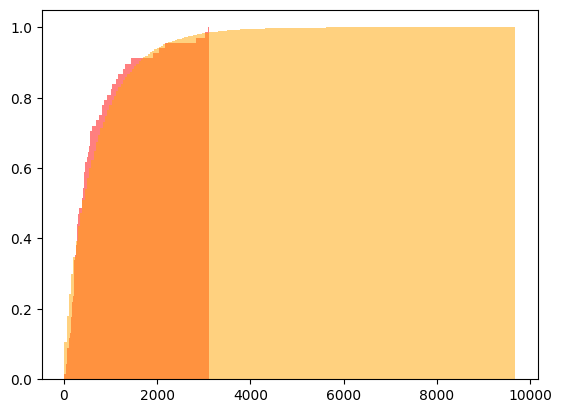

In [36]:
def compare_simulated_to_original(
    original_column, simulated_column, num_bins=200, cumulative=True
):
    plt.hist(
        original_column,
        bins=num_bins,
        color="red",
        alpha=0.5,
        label="Zone 1",
        density=True,
        cumulative=cumulative,
    )
    plt.hist(
        simulated_column,
        bins=num_bins,
        color="orange",
        alpha=0.5,
        label="Simulated 1",
        density=True,
        cumulative=cumulative,
    )

    ax1.set_xlabel(original_column.name)
    ax1.set_ylabel("Frequency Density")
    ax1.legend()


compare_simulated_to_original(zone1["kg"], simulated1["kg"])

In [37]:
# Determine the latest end datetime of the two dataframes
max_datetime = min(simulated1["datetime"].max(), simulated2["datetime"].max())

# Set the end datetime of both dataframes to be the same
simulated1 = simulated1[simulated1["datetime"] <= max_datetime]
simulated2 = simulated2[simulated2["datetime"] <= max_datetime]

# Merge the two dataframes together, sort by datetime, and reset the index
simulated_df = pd.concat([simulated1, simulated2])
simulated_df = simulated_df.sort_values("datetime")
simulated_df = simulated_df.reset_index(drop=True)

In [38]:
simulated_df.describe()

,timediv h,datetime,kg,m/s,kj,zone
count,82990.000000,82990,82990.000000,82990.000000,82990.000000,82990.000000
mean,42.049669,2099-05-20 16:31:28.492589056,494.691541,18.107391,42.575028,1.321219
min,1.000000,2000-01-02 06:00:00,3.000000,0.600000,0.016640,1.000000
25%,13.000000,2049-10-09 11:30:00,72.000000,8.100000,7.885440,1.000000
50%,28.000000,2099-05-12 20:00:00,223.000000,10.000000,22.324875,1.000000
75%,56.000000,2148-10-15 22:00:00,655.750000,33.800000,53.338313,2.000000
max,615.000000,2199-01-19 04:00:00,9677.000000,57.700000,979.219610,2.000000
std,44.256476,NaN,672.732283,13.966979,57.844791,0.466948


In [39]:
# here i look at the tail to make shure the dates got calculated correctly.
simulated_df.tail(20)

,timediv h,datetime,kg,m/s,kj,zone
82970,8.0,2199-01-05 16:00:00,979.0,8.2,32.913980,1
82971,59.0,2199-01-05 19:00:00,179.0,47.2,199.391680,2
82972,12.0,2199-01-06 04:00:00,1149.0,12.7,92.661105,1
82973,33.0,2199-01-07 13:00:00,1103.0,10.8,64.326960,1
82974,44.0,2199-01-07 15:00:00,15.0,31.4,7.394700,2
82975,5.0,2199-01-07 18:00:00,956.0,7.2,24.779520,1
82976,7.0,2199-01-08 01:00:00,29.0,8.5,1.047625,1
82977,79.0,2199-01-11 08:00:00,59.0,8.6,2.181820,1
82978,94.0,2199-01-11 13:00:00,106.0,43.4,99.828680,2
82979,9.0,2199-01-11 17:00:00,338.0,4.4,3.271840,1


because the reaction time is 24h we will asume that the nets will get emptied every evening if there are stones in it.


In [40]:
# add a column that calculates the cumulative kg already in the net.

# first group the data by date
grouped_df = simulated_df.groupby(simulated_df["datetime"].dt.date)

# then calculate the cumulative sum of 'kg' within each group
simulated_df["cumulative_kg"] = grouped_df["kg"].cumsum()
# and subtract the 'kg' valueof the new stone to get the weight in the net
simulated_df["cumulative_kg"] = (
    simulated_df["cumulative_kg"] - simulated_df["kg"]
)

In [41]:
# should we disregard the rest stones of the day if the net broke trough?
# after this the road probably gets closed

# Add a new column 'breakthrough'
simulated_df["breakthrough"] = 0

# Set breakthrough to 1 where conditions are met
condition1 = simulated_df["kj"] > 1000
condition2 = (simulated_df["cumulative_kg"] > 2000) & (
    simulated_df["kj"] > 500
)
simulated_df.loc[condition1 | condition2, "breakthrough"] = 1

In [42]:
# here i look at the tail to make shure the cumulative_kg and breakthrough got calculated correctly.

simulated_df.tail(20)

,timediv h,datetime,kg,m/s,kj,zone,cumulative_kg,breakthrough
82970,8.0,2199-01-05 16:00:00,979.0,8.2,32.913980,1,183.0,0
82971,59.0,2199-01-05 19:00:00,179.0,47.2,199.391680,2,1162.0,0
82972,12.0,2199-01-06 04:00:00,1149.0,12.7,92.661105,1,0.0,0
82973,33.0,2199-01-07 13:00:00,1103.0,10.8,64.326960,1,0.0,0
82974,44.0,2199-01-07 15:00:00,15.0,31.4,7.394700,2,1103.0,0
82975,5.0,2199-01-07 18:00:00,956.0,7.2,24.779520,1,1118.0,0
82976,7.0,2199-01-08 01:00:00,29.0,8.5,1.047625,1,0.0,0
82977,79.0,2199-01-11 08:00:00,59.0,8.6,2.181820,1,0.0,0
82978,94.0,2199-01-11 13:00:00,106.0,43.4,99.828680,2,59.0,0
82979,9.0,2199-01-11 17:00:00,338.0,4.4,3.271840,1,165.0,0


In [43]:
# Calculate the probability of a breakthrough
first_day = simulated_df["datetime"].min().date()
last_day = simulated_df["datetime"].max().date()
num_days = (last_day - first_day).days + 1

breaktroughs_prbability = (simulated_df["breakthrough"] == 1).sum() / num_days
breaktroughs_prbability

8.252867871585376e-05

In [44]:
simulated_df["breakthrough"].value_counts()

breakthrough
0    82984
1        6
Name: count, dtype: int64

Auf diesem [Artikel der BAZ](https://www.bazonline.ch/autos-werden-immer-breiter-und-laenger-288912673833) stützen wir unsere Annahme dass Autos durchschnittlich 4.4m lang sind. Auf diesem [Artikel](https://www.sciencedirect.com/science/article/abs/pii/S0378437102014577) stützen wir die Annahme das die mittlere Reaktionszeit ~1s ist. 

In [45]:
# TODO: this function is used in the sumulation not only in the testing phase...
# a 4.4m car driving 60 will be in this zone for:
def calculate_danger_time(velocity=(60 / 3.6), length=4.4, reaction_time=1):
    print("velocity:", velocity, "m/s")
    # TODO: document how danger time is calculated
    danger_time = length / velocity + reaction_time
    print("danger time: ", danger_time, "s")
    # with 1200 cars a day this will be that amount of seconds in danger:
    total_danger_time = 1200 * danger_time
    print("total danger time:", total_danger_time, "s")
    # precentage of cars being in danger per day:
    danger_time_proportion = total_danger_time / (24 * 60 * 60)
    print("danger time proportion: ", danger_time_proportion * 100, "%")
    return danger_time_proportion


danger_time_proportion = calculate_danger_time()

# how likely is it that a car will be in danger and the net will break trough?
dead_probability = breaktroughs_prbability * danger_time_proportion
print("dead probability:", dead_probability * 100, "%")

velocity: 16.666666666666668 m/s
danger time:  1.264 s
total danger time: 1516.8 s
danger time proportion:  1.7555555555555553 %
dead probability: 0.0001448836804122766 %


In [46]:
(simulated_df["breakthrough"] == 1).sum()

6

## The Simulation

In [47]:
def simulate_combined():
    # simulated zones
    sim1 = simulate_zone(zone1)
    sim1["zone"] = 1
    sim2 = simulate_zone(zone2)
    sim2["zone"] = 2
    sim1.describe()

    # Determine the latest end datetime of the two dataframes
    max_datetime = min(sim1["datetime"].max(), sim2["datetime"].max())

    # Set the end datetime of both dataframes to be the same
    sim1 = sim1[sim1["datetime"] <= max_datetime]
    sim2 = sim2[sim2["datetime"] <= max_datetime]

    # Merge the two dataframes together, sort by datetime, and reset the index
    simulated_df = pd.concat([sim1, sim2])
    simulated_df = simulated_df.sort_values("datetime")
    simulated_df = simulated_df.reset_index(drop=True)

    # add a column that calculates the cumulative kg already in the net.
    # first group the data by date
    grouped_df = simulated_df.groupby(simulated_df["datetime"].dt.date)

    # then calculate the cumulative sum of 'kg' within each group
    simulated_df["cumulative_kg"] = grouped_df["kg"].cumsum()
    # and subtract the 'kg' valueof the new stone to get the weight in the net
    simulated_df["cumulative_kg"] = (
        simulated_df["cumulative_kg"] - simulated_df["kg"]
    )

    # Add a new column 'breakthrough' and set it to 1 where conditions are met
    simulated_df["breakthrough"] = 0
    condition1 = simulated_df["kj"] > 1000
    condition2 = (simulated_df["cumulative_kg"] > 2000) & (
        simulated_df["kj"] > 500
    )
    simulated_df.loc[condition1 | condition2, "breakthrough"] = 1

    # Calculate days passed
    first_day = simulated_df["datetime"].min().date()
    last_day = simulated_df["datetime"].max().date()
    num_days = (last_day - first_day).days + 1

    breakthroughs = simulated_df["breakthrough"].sum()

    return breakthroughs, num_days

In [48]:
def simulate_years(years=10000):
    breakthroughs = 0
    num_days = 0
    while num_days < (years * 365):
        a, b = simulate_combined()
        breakthroughs += a
        num_days += b
    probability = breakthroughs / num_days
    return probability

### How many years should we simulate?

In [49]:
def run_simulation_until_convergence(
    years=100_000, threshold=0.000001, max_years=1_000_000, cnt_max=5
):
    prev_prob, cnt = 100, 0
    while years < max_years:
        curr_prob = simulate_years(years)
        cnt = cnt + 1 if abs(curr_prob - prev_prob) < threshold else 0
        print(f"After {years} years the car hit probability is {curr_prob}")
        if cnt >= cnt_max:
            print(
                f"Converged after {years} years with a car hit probability of {curr_prob}"
            )
            return curr_prob

        prev_prob = curr_prob
        years += 100_000
    print(
        f"stopped after {years} (max: {max_years}) without convergence. Final probability: {curr_prob}"
    )
    return curr_prob


# run_simulation_until_convergence()

First version:
```
After 1000 years the car hit probability is 3.561263317070231e-05
After 2000 years the car hit probability is 5.364693083413492e-05
After 4000 years the car hit probability is 3.405758089002938e-05
After 8000 years the car hit probability is 4.217577456981547e-05
After 16000 years the car hit probability is 4.3377030608425545e-05
After 32000 years the car hit probability is 4.1614637710042e-05
After 64000 years the car hit probability is 4.30908377539241e-05
After 128000 years the car hit probability is 4.318400823489107e-05
After 256000 years the car hit probability is 4.175662569138142e-05
Converged after 256000 years with a car hit probability of 4.175662569138142e-05
```

second version:
```
After 100000 years the car hit probability is 4.370946770867339e-05
After 200000 years the car hit probability is 4.0979629962153794e-05
After 300000 years the car hit probability is 4.304146962984774e-05
After 400000 years the car hit probability is 4.2160043179880796e-05
After 500000 years the car hit probability is 4.128412826292135e-05
After 600000 years the car hit probability is 4.216004440371104e-05
After 700000 years the car hit probability is 4.218535823026752e-05
After 800000 years the car hit probability is 4.122875384867198e-05
Converged after 800000 years with a car hit probability of 4.122875384867198e-05
```

## Running Simulation
TODO: find better source

[link](https://www.eea.europa.eu/data-and-maps/figures/term29-occupancy-rates-in-passenger-transport-1) zeigt dass in der Schweiz im Jahr 2008 durchschnittlich ~1.5 Passiere pro Auto sitzen. Wir nehmen an dass dies auch heute noch so ist. Die Annahme dass man einen 50% Wahrscheinlichkeit hat zu überleben bei einer Kollision mit einer Wand (Felsen von über 2t vergleichen wir mit einer Wand) entnehmen wir diesem [Artikel](https://www.sciencedirect.com/science/article/abs/pii/S0001457519301058). Den Bremsweg haben wir vernachlässigt, weil wir den Grenzwert von 0.0001 schon überschritten haben. Würde man den Bremsweg berücksichtigen würde, würde die Wahrscheinlichkeit, dass jemand stirbt, weiter steigen.

In [50]:
# how likely is it that a car will be in danger and the net will break trough?
print('danger time per day:', danger_time_proportion * 100, '%')
p_rock_breaks_net_per_day = simulate_years(800_000)
print('rock breaks net per day:', p_rock_breaks_net_per_day * 100, '%')
p_car_hit_per_day = p_rock_breaks_net_per_day * danger_time_proportion
print('car hit per day:', p_car_hit_per_day * 100, '%')
p_car_hit_next_year = p_car_hit_per_day * 365
print('car hit next year:', p_car_hit_next_year * 100, '%')
mean_number_of_passengers, p_dying_during_crash = 1.5, 0.5
print('mean number of passengers:', mean_number_of_passengers)
print('probability of dying during crash at 60 km/h:', p_dying_during_crash * 100, '%')
p_dead_person_next_year = (
    p_car_hit_next_year * mean_number_of_passengers * p_dying_during_crash
)
print(
    "Probability that one person dies next year:",
    p_dead_person_next_year * 100,
    "%",
)

danger time per day: 1.7555555555555553 %


rock breaks net per day: 0.004278985088971321 %
car hit per day: 7.511996045082985e-05 %
car hit next year: 0.027418785564552895 %
mean number of passengers: 1.5
probability of dying during crash at 60 km/h: 50.0 %
Probability that one person dies next year: 0.02056408917341467 %
